## Day 15-18


*   Study ***image segmentation*** techniques, including semantic segmentation and instance segmentation.
*   Lern and implement **U-Net** for a segmentation task.


**NOTE❗:** I downloaded this notebook from Kaggle because I needed additional GPUs to train the U-Net model. You may notice some references and code specific to Kaggle throughout.

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub

humansintheloop_semantic_segmentation_of_aerial_imagery_path = kagglehub.dataset_download('humansintheloop/semantic-segmentation-of-aerial-imagery')

print('Data source import complete.')


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate
from tensorflow.keras.metrics import MeanIoU

import os
import cv2
from PIL import Image
from skimage.util import view_as_blocks  # instead of `patchify` module

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [ ]:
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     print('Running on TPU ', tpu.master())
# except ValueError:
#     tpu = None

# if tpu:
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# else:
#     strategy = tf.distribute.get_strategy()

# print("REPLICAS: ", strategy.num_replicas_in_sync)

## **Loading Aerial Imagery Semantic Segmentation Dataset**

[**Dataset Link**](https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery/data)

The dataset consists of aerial imagery of Dubai obtained by MBRSC satellites and annotated with pixel-wise semantic segmentation in **6 classes**. The total volume of the dataset is **72 images grouped into 6 larger tiles**. Each tile consists of images of a specific size. The classes are:

* **Building**: #3C1098
* **Land** (unpaved area): #8429F6
* **Road**: #6EC1E4
* **Vegetation**: #FEDD3A
* **Water**: #E2A929
* **Unlabeled**: #9B9B9B
---

[**YouTube tutorial**](https://youtu.be/jvZm8REF2KY?si=euMnprmQnAVo4938)

I'll stick to the tutorial's author approah of dataset images preprocessing, as they all are of different sizes, so we'll use **`patchify`** to **patchify our images** (the process of dividing an image into smaller, non-overlapping or overlapping patches (sub-images)), but first we'll **crop the images to dimensions that are multiples of 256**, so that both the width and height are divisible by 256.

---

Use **patchify**....
* **Tile 1:** 797 x 644 --> 768 x 512 --> **6** "sub-images"
* **Tile 2:** 509 x 544 --> 512 x 256 --> **2** "sub-images"
* **Tile 3:** 682 x 658 --> 512 x 512  --> **4** "sub-images"
* **Tile 4:** 1099 x 846 --> 1024 x 768 --> **12** "sub-images"
* **Tile 5:** 1126 x 1058 --> 1024 x 1024 --> **16** "sub-images"
* **Tile 6:** 859 x 838 --> 768 x 768 --> **9** "sub-images"
* **Tile 7:** 1817 x 2061 --> 1792 x 2048 --> **56** "sub-images"
* **Tile 8:** 2149 x 1479 --> 1280 x 2048 --> **40** "sub-images"
* Total 9 images in each folder * (145 patches) = 1305

### **Total 1305 patches of size 256x256**

In [ ]:
os.getcwd()

'/kaggle/working'

In [ ]:
root_directory = "/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset"
patch_size = 256

root_directory

'/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset'

In [ ]:
os.listdir(root_directory)

['Tile 7',
 'Tile 8',
 'Tile 2',
 'Tile 5',
 'Tile 1',
 'Tile 3',
 'classes.json',
 'Tile 6',
 'Tile 4']

In [ ]:
# scaler = MinMaxScaler()  # you can use this scaler instead of dividing image by 255., but the latter approach seems to be more robust and efficient, so I am going to stick to it
image_dataset = []

for path, _, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == "images":
        images = sorted(os.listdir(path))  # list all image names in this subdir
        for i, image_name in enumerate(images):
            if image_name.endswith(".jpg"):
                image = cv2.imread(os.path.join(path, image_name), 1)  # read image as BGR
                SIZE_X = (image.shape[1] // patch_size) * patch_size  # the nearest width size divisible by our patch size
                SIZE_Y = (image.shape[0] // patch_size) * patch_size
                image = Image.fromarray(image)
                image = image.crop((0, 0, SIZE_X, SIZE_Y))  # crop from the top left corner
                image = np.array(image)

                # print("Now patchifying image: ", os.path.join(path, image_name))
                patches_img = view_as_blocks(image, (patch_size, patch_size, 3))
                # print("Patches shape: ", patches_img.shape)

                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        single_patch_img = patches_img[i, j, :, :]  # extracting a single image(256x256x3 patch)
                        single_patch_img = single_patch_img / 255.
                        single_patch_img = single_patch_img[0]  # dropping the extra dimension added by "patchification"
                        image_dataset.append(single_patch_img)

In [ ]:
mask_dataset = []

for path, _, filenames in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]

    if dirname == "masks":
        masks = sorted(os.listdir(path))
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):
                mask = cv2.imread(os.path.join(path, mask_name), 1)  # read image in BGR
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1] // patch_size) * patch_size
                SIZE_Y = (mask.shape[0] // patch_size) * patch_size
                mask = Image.fromarray(mask)
                mask = mask.crop((0, 0, SIZE_X, SIZE_Y))
                mask = np.array(mask)

                # print("Now patchifying mask: ", os.path.join(path, mask_name))
                patches_mask = view_as_blocks(mask, (patch_size, patch_size, 3))

                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):
                        single_patch_mask = patches_mask[i, j, :, :]
                        single_patch_mask = single_patch_mask[0]  # drop the extra dimension
                        mask_dataset.append(single_patch_mask)

In [ ]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

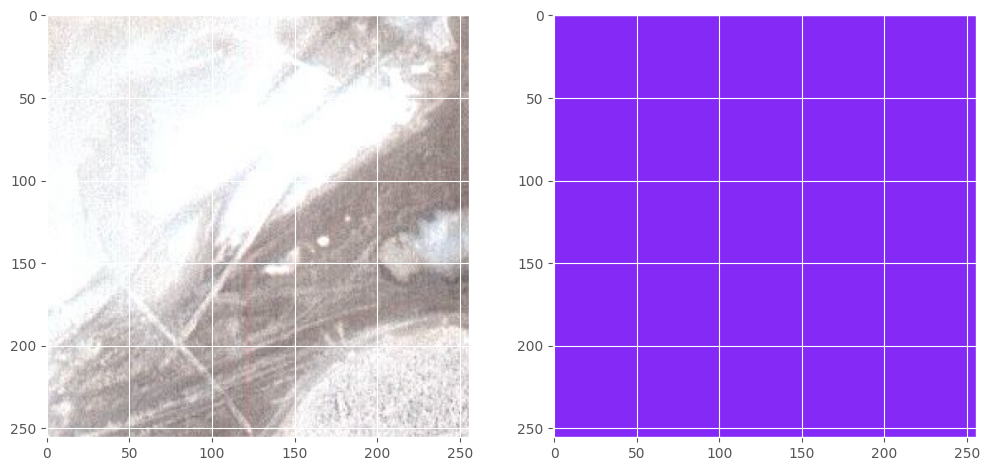

In [ ]:
# Sanity check, view few images
import random

image_number = random.randint(0, len(image_dataset))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])

plt.subplot(122)
plt.imshow(mask_dataset[image_number])

plt.show()

## Convert HEX values (classes colors) to RGB tuple, then to corresponding classes' numbers and then one-hot encode
### Handling the classes' colors

**RGB to HEX**: (Hexadecimel --> base 16)
This number divided by sixteen (integer division; ignoring any remainder) gives the first hexadecimal digit (between 0 and F, where the letters A to F represent the numbers 10 to 15). The remainder gives the second hexadecimal digit.
0-9 --> 0-9
10-15 --> A-F

*Example* : RGB --> R=201, G=, B=

R = 201/16 = 12 with remainder of 9. So hex code for R is C9 (remember C=12)

Calculating RGB from HEX: #3C1098

3C = 3*16 + 12 = 60

10 = 1*16 + 0 = 16

98 = 9*16 + 8 = 152


In [ ]:
int("3C", 16)

60

In [ ]:
# Converting all provided classes' HEX values to RGB

Building = "#3C1098".lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4)))  # 60, 16, 152

Land = "#8429F6".lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4)))  # 132, 41, 246

Road = "#6EC1E4".lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4)))  # 110, 193, 228

Vegetation= "#FEDD3A".lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4)))  # 254, 221, 58

Water = "#E2A929".lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4)))  # 226, 169, 41

Unlabeled = "#9B9B9B".lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4)))  # 155, 155, 155

In [ ]:
# Now replace RGB to integer values to be used as labels
def RGB_to_2D_label(label):
    """
    Supply our labels masks as input in RGB format.
    Replace pixels with specific "class number" (e.g., Building = 0, Land = 1, and so on.)
    """
    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg[np.all(label == Building, axis=-1)] = 0
    label_seg[np.all(label == Land, axis=-1)] = 1
    label_seg[np.all(label == Road, axis=-1)] = 2
    label_seg[np.all(label == Vegetation, axis=-1)] = 3
    label_seg[np.all(label == Water, axis=-1)] = 4
    label_seg[np.all(label == Unlabeled, axis=-1)] = 5

    label_seg = label_seg[:, :, 0]  # Taking only the first channel, because channels 0-2 are the same (beforehand, they were represented as 3 RGB channels)

    return label_seg

In [ ]:
def one_hot_to_rgb(one_hot_tensor):
    # Define RGB colors for each class (you can adjust colors as needed)
    color_map = np.array([Building, Land, Road, Vegetation, Water, Unlabeled])

    # Get the class index for each pixel (along the third dimension)
    class_indices = np.argmax(one_hot_tensor, axis=-1)

    # Map each index to its RGB color
    rgb_image = color_map[class_indices]

    return rgb_image

In [ ]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = RGB_to_2D_label(mask_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)
labels.shape

(1305, 256, 256, 1)

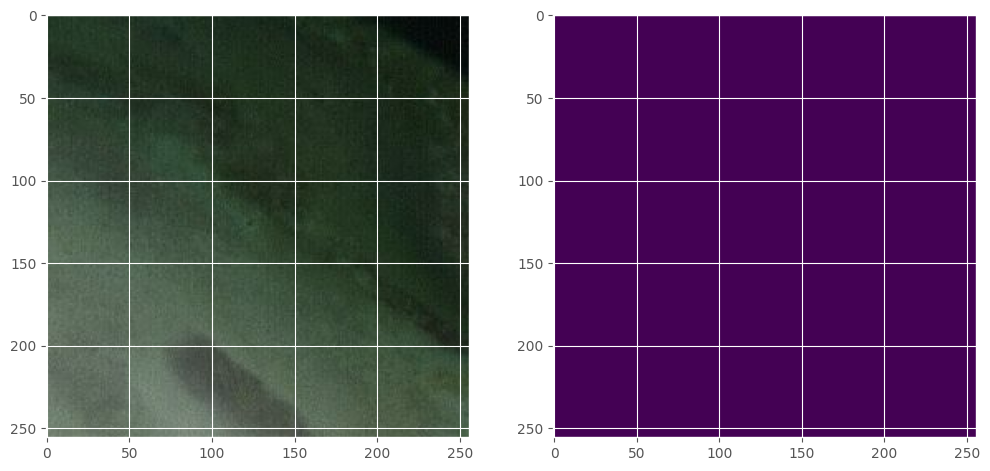

In [ ]:
# Another sanity check
image_number = random.randint(0, len(image_dataset))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])

plt.subplot(122)
plt.imshow(labels[image_number][:, :, 0])

plt.show()

In [ ]:
n_classes = len(np.unique(labels))

In [ ]:
# One-hot encoding labels' numbers (6 in total)
from keras.utils import to_categorical

labels_cat = to_categorical(labels, num_classes=n_classes)
labels_cat.shape

(1305, 256, 256, 6)

## Dividing our datasets into training and testing datasets

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size=0.2, random_state=42)
len(X_train), len(y_train), len(X_test), len(y_test)

(1044, 1044, 261, 261)

## **U-Net Model Building**

* [**Research paper**](https://arxiv.org/pdf/1505.04597v1)

* [**Code source tutorial**](https://youtu.be/GAYJ81M58y8?si=9yekGJvsIG32dYgP)

In [ ]:
# Defining the convolutional block which is present in each layer of U-Net (so that we could reuse it)
def conv_block(input, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(input)
    x = BatchNormalization()(x)  # Not in the original network
    x = Activation("relu")(x)

    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)  # Not in the original network
    x = Activation("relu")(x)

    return x

In [ ]:
# Encoder block: Conv block followed by max pooling layer
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)

    return x, p

In [ ]:
# Decoder block: we up-sample our input features (to double the size of features), then
# skip features (the output from the corresponding layer of encoder) are concatenated with the up-sampled features and, finally, use our conv block
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)

    return x

In [ ]:
# Build U-Net using the defined blocks
def build_unet(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encoder layers
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)  # Bridge

    # Decoder layers
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(num_classes, (1, 1), activation="softmax")(d4)

    model = Model(inputs=inputs, outputs=outputs, name="U-Net")

    return model

## U-Net Model Training

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

### Defining Custom Evaluation Metrics and Losses (**Dice Coefficient, Jaccard Coefficient, Dice Loss, Focal Loss**)

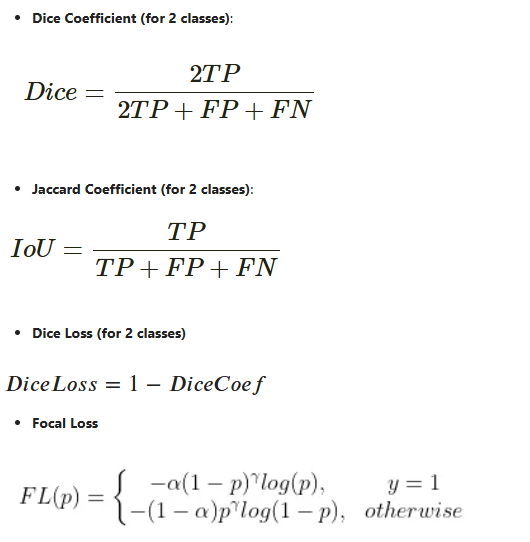

In [ ]:
# Dice Coefficient = F1 Score: a harmonic mean of precision and recall
def dice_coef(y_true, y_pred, smooth=1e-12):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)

    TP = tf.reduce_sum(y_true_f * y_pred_f)  # the same as np.sum()
    total_sum = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)

    return (2 * TP + smooth) / (total_sum + smooth)  # we add smooth in order to avoid division by zero

In [ ]:
# Dice loss = 1 - Dice_Coef, to generalise to n classes, we just take a mean of dice losses of each class
def dice_loss_multilabel(y_true, y_pred, num_classes=6):
    dice = 0
    for index in range(num_classes):
        dice -= dice_coef(y_true[..., index], y_pred[..., index])
    return (num_classes + dice) / num_classes  # the mean of dice losses

In [ ]:
# Gonna need this for evaluation metrics
def jaccard_coef(y_true, y_pred, smooth=1e-12):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)

    TP = tf.reduce_sum(y_true_f * y_pred_f)
    total_sum = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)

    return (TP + smooth) / (total_sum - TP + smooth)  # we add smooth in order to avoid division by zero

#### So, I have defined Dice Loss and showed a formula of Focal Loss, but for my model I am going to use `tf.keras.losses.CategoricalFocalCrossentropy`

In [ ]:
model = build_unet((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), 6)
metrics = ['accuracy', jaccard_coef]

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.CategoricalFocalCrossentropy(),
             metrics=metrics)
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,055,622 (118.47 MB)

 Trainable params: 31,043,846 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-787decd6-dd00-d8d9-969b-e88a8aba8431)
GPU 1: Tesla T4 (UUID: GPU-8d93a282-a6b8-650c-3111-f598fc853f80)


In [ ]:
# from tensorflow.keras import mixed_precision

# policy = mixed_precision.Policy('float32')
# mixed_precision.set_global_policy(policy)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(8).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(8).prefetch(tf.data.AUTOTUNE)

history = model.fit(train_ds, epochs=100, validation_data=test_ds)

In [ ]:
history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test))

Epoch 1/100


I0000 00:00:1730128888.373920     222 service.cc:145] XLA service 0x7efcc0043690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730128888.373981     222 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730128888.373988     222 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1730128936.487558     222 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


131/131 ━━━━━━━━━━━━━━━━━━━━ 168s 829ms/step - accuracy: 0.6682 - jaccard_coef: 0.2851 - loss: 0.1747 - val_accuracy: 0.5632 - val_jaccard_coef: 0.2114 - val_loss: 0.2231
Epoch 2/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 64s 491ms/step - accuracy: 0.7529 - jaccard_coef: 0.3591 - loss: 0.0933 - val_accuracy: 0.5473 - val_jaccard_coef: 0.2371 - val_loss: 0.2826
Epoch 3/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 501ms/step - accuracy: 0.7648 - jaccard_coef: 0.3740 - loss: 0.0859 - val_accuracy: 0.5883 - val_jaccard_coef: 0.2875 - val_loss: 0.2772
Epoch 4/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 503ms/step - accuracy: 0.7583 - jaccard_coef: 0.3717 - loss: 0.0916 - val_accuracy: 0.6897 - val_jaccard_coef: 0.3607 - val_loss: 0.1023
Epoch 5/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 504ms/step - accuracy: 0.7685 - jaccard_coef: 0.3843 - loss: 0.0875 - val_accuracy: 0.7801 - val_jaccard_coef: 0.3844 - val_loss: 0.0778
Epoch 6/100
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 504ms/step - accuracy: 0.7813 - jaccard_coef: 0.4019 - l

In [ ]:
# Accuracy and losses comparison plotting function
def plot_jaccard_coef_and_loss_comparison(history, epochs):
    plt.figure(figsize=(10, 10))
    acc = history.history['jaccard_coef']
    val_acc = history.history['val_jaccard_coef']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)
    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Jaccard Coefficient')
    plt.plot(epochs_range, val_acc, label='Validation Jaccard Coefficient')
    plt.legend(loc='lower right')
    plt.title(f'Training and Validation Jaccard Coefficients')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'Training and Validation Loss')

    plt.show()

<Figure size 1000x1000 with 0 Axes>

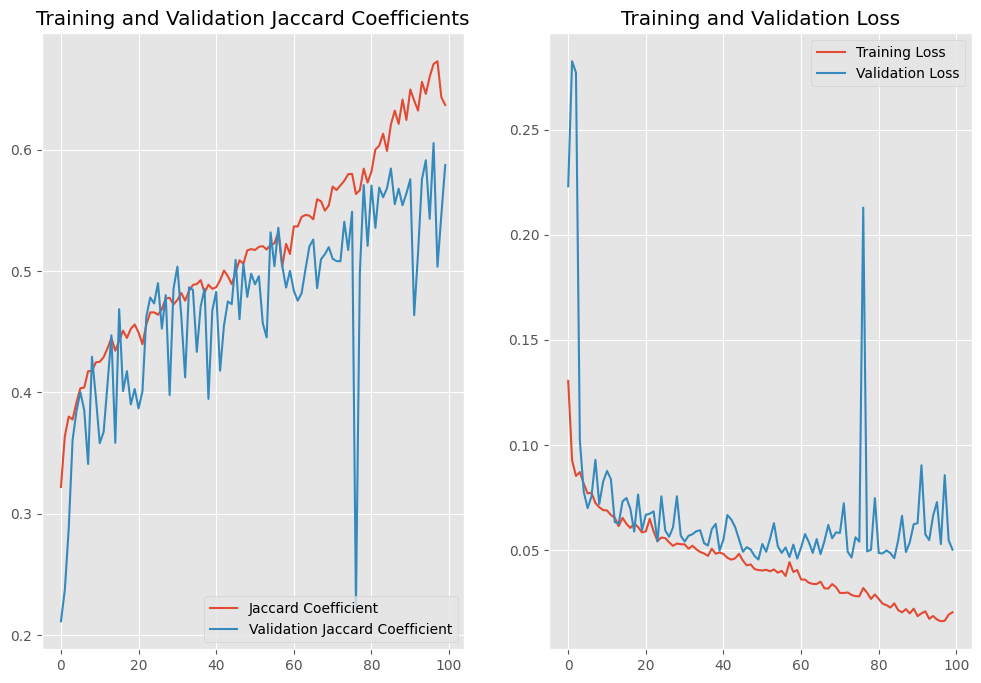

In [ ]:
plot_jaccard_coef_and_loss_comparison(history, epochs=100)

## Checking Model's Predictions

In [ ]:
def plot_segmentation(true_mask, pred_mask, image=None):
    """
    Plots the original image (if provided), the ground truth mask, and the predicted mask.

    Args:
    - true_mask (numpy array or tensor): The ground truth segmentation mask.
    - pred_mask (numpy array or tensor): The predicted segmentation mask.
    - image (numpy array or tensor, optional): The original image. Defaults to None.
    """
    plt.figure(figsize=(12, 6))

    # Plot original image if provided
    if image is not None:
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis("off")
        plt.grid(False)

    # Plot true segmentation mask
    plt.subplot(1, 3, 2 if image is not None else 1)
    plt.imshow(true_mask, cmap="gray")
    plt.title("True Segmentation")
    plt.axis("off")
    plt.grid(False)

    # Plot predicted segmentation mask
    plt.subplot(1, 3, 3 if image is not None else 2)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Segmentation")
    plt.axis("off")
    plt.grid(False)

    plt.tight_layout()
    plt.show()

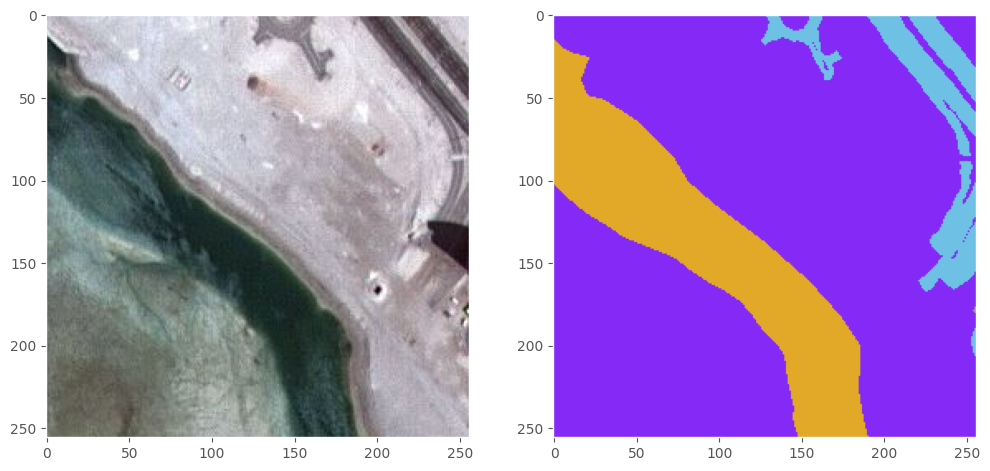

In [ ]:
random.seed(42)
image_number = random.randint(0, len(X_test))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_test[image_number])
plt.grid(False)

plt.subplot(122)
plt.imshow(one_hot_to_rgb(y_test[image_number]))
plt.grid(False)

plt.show()

In [ ]:
preds = model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 556ms/step


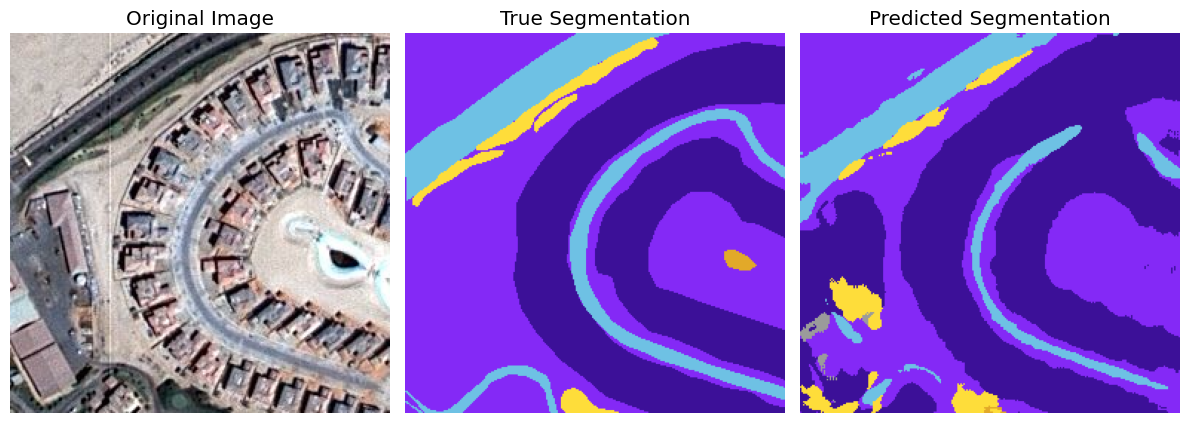

In [ ]:
image_number = random.randint(0, len(X_test))

pred_mask = one_hot_to_rgb(preds[image_number])
plot_segmentation(one_hot_to_rgb(y_test[image_number]), pred_mask, X_test[image_number])

## Of course, my custom U-Net model is not ideal, but I think that some adjustments to the model's structure could improve its performance, but I am going to leave it here, because I don't have that many computational resources to train even bigger model.

## Model Saving

In [ ]:
model.save("/kaggle/working/my_segmentation_model.h5")

In [ ]:
model.save("/kaggle/working/my_segmentation_model.keras")

In [ ]:
!ls -1 /kaggle/working

my_segmentation_model.h5
my_segmentation_model.keras


# Great, Job is Done 🥳